Author: Zhewei Yao <https://github.com/yaozhewei>, Amir Gholami <http://amirgholami.org/>_


This tutorial shows how to compute the Hessian information using (randomized) numerical linear algebra for both explicit Hessian (the matrix is given) as well as implicit Hessian (the matrix is ungiven).

We'll start by doing the necessary imports:

In [1]:
import numpy as np
import torch 
import copy
from torchvision import datasets, transforms
from utils import * # get the dataset
from pyhessian import hessian # Hessian computation
from density_plot import get_esd_plot # ESD plot
from pytorchcv.model_provider import get_model as ptcv_get_model # model

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# enable cuda devices
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# The following part shows how to use power iteration to get the top eigenvalue of the Hessian

## We first show an example with Numpy

In [3]:
n = 10 # the matrix size

# generate the matrix
A = np.random.randn(n, n)
B = A @ A.T

In [4]:
# use np.eigs to get the top eigenvalue of B
eigs, _ = np.linalg.eig(B)
print(f"The top eigenvalue of B is: {np.sort(eigs)[-1]}")

The top eigenvalue of B is: 40.77136898528639


### Power Iteration: https://en.wikipedia.org/wiki/Power_iteration
The algorithm is very simple and efficiet to compute the top eigenvalue:
$$v_{i+1} = \frac{Bv_i}{\|Bv_i\|}.$$

In [5]:
# use power iteration to get the top eigenvalue of B
v = np.random.randn(n, 1)

for i in range(15):
    v = v / np.linalg.norm(v)
    print(f'Step {i+1}, Current estimated top eigvalue: {v.T @ B @ v} ')
    v = B @ v


Step 1, Current estimated top eigvalue: [[17.27665187]] 
Step 2, Current estimated top eigvalue: [[39.13608748]] 
Step 3, Current estimated top eigvalue: [[40.32982995]] 
Step 4, Current estimated top eigvalue: [[40.61049938]] 
Step 5, Current estimated top eigvalue: [[40.7102669]] 
Step 6, Current estimated top eigvalue: [[40.74798436]] 
Step 7, Current estimated top eigvalue: [[40.76240414]] 
Step 8, Current estimated top eigvalue: [[40.76793008]] 
Step 9, Current estimated top eigvalue: [[40.77004938]] 
Step 10, Current estimated top eigvalue: [[40.77086252]] 
Step 11, Current estimated top eigvalue: [[40.77117458]] 
Step 12, Current estimated top eigvalue: [[40.77129435]] 
Step 13, Current estimated top eigvalue: [[40.77134033]] 
Step 14, Current estimated top eigvalue: [[40.77135799]] 
Step 15, Current estimated top eigvalue: [[40.77136476]] 


## Use power iteration for NNs

In [6]:
# get the model 
model = ptcv_get_model("resnet20_cifar10", pretrained=True)
# change the model to eval mode to disable running stats upate
model.eval()

# create loss function
criterion = torch.nn.CrossEntropyLoss()

# get dataset 
train_loader, test_loader = getData()

# for illustrate, we only use one batch to do the tutorial
for inputs, targets in train_loader:
    break

# we use cuda to make the computation fast
model = model.cuda()
inputs, targets = inputs.cuda(), targets.cuda()



Files already downloaded and verified


In [7]:
# create the hessian computation module
hessian_comp = hessian(model, criterion, data=(inputs, targets), cuda=True)

In [8]:
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues()
print(f'The top eigenvalue of this model is: {top_eigenvalues}')

The top eigenvalue of this model is: [97.01739501953125]


In [9]:
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=2)
print(f'The top two eigenvalues of this model are: {top_eigenvalues}')

The top two eigenvalues of this model are: [97.08731842041016, 66.16024780273438]


### Why do we need this?
1. It can help you to analyze the flat/sharpness of your model.
2. It can help you to create wonderful loss plot.

In [10]:
# get the top eigenvector
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues()

In [11]:
# model perturbation helper
def get_params(model_orig,  model_perb, direction, alpha):
    for m_orig, m_perb, d in zip(model_orig.parameters(), model_perb.parameters(), direction):
        m_perb.data = m_orig.data + alpha * d
    return model_perb

Text(0.5, 0, 'Perturbation')

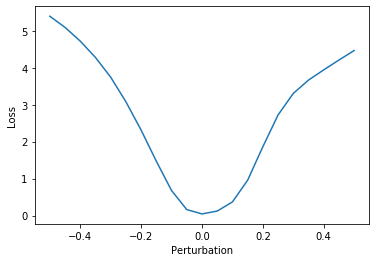

In [12]:
# used to perturb your model 
lams = np.linspace(-0.5, 0.5, 21).astype(np.float32)

loss_list = []

# create a copy of the model
model_perb = ptcv_get_model("resnet20_cifar10", pretrained=True)
model_perb.eval()
model_perb = model_perb.cuda()

for lam in lams: 
    model_perb = get_params(model, model_perb, top_eigenvector[0], lam)
    loss_list.append(criterion(model_perb(inputs), targets).item())

plt.plot(lams, loss_list)
plt.ylabel('Loss')
plt.xlabel('Perturbation')

Text(0.5, 0, 'Perturbation')

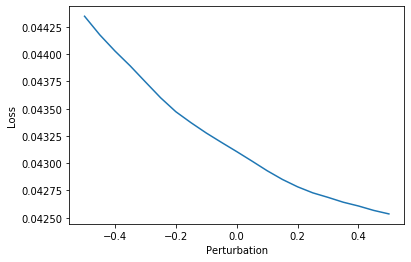

In [13]:
from pyhessian.utils import normalization

# generate random vector to do the loss plot

v = [torch.randn_like(p) for p in model.parameters()]
v = normalization(v)


# used to perturb your model 
lams = np.linspace(-0.5, 0.5, 21).astype(np.float32)

loss_list = []

# create a copy of the model
model_perb = ptcv_get_model("resnet20_cifar10", pretrained=True)
model_perb.eval()
model_perb = model_perb.cuda()

for lam in lams: 
    model_perb = get_params(model, model_perb, v, lam)
    loss_list.append(criterion(model_perb(inputs), targets).item())

plt.plot(lams, loss_list)
plt.ylabel('Loss')
plt.xlabel('Perturbation')

Text(0.5, 0, 'Perturbation')

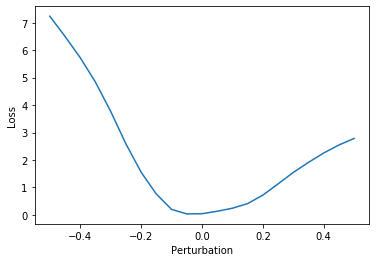

In [14]:
from pyhessian.utils import normalization




# used to perturb your model 
lams = np.linspace(-0.5, 0.5, 21).astype(np.float32)

loss_list = []

# create a copy of the model
model_perb = ptcv_get_model("resnet20_cifar10", pretrained=True)
model_perb.eval()
model_perb = model_perb.cuda()

# generate gradient vector to do the loss plot
loss = criterion(model_perb(inputs), targets)
loss.backward()

v = [p.grad.data for p in model_perb.parameters()]
v = normalization(v)
model_perb.zero_grad()


for lam in lams: 
    model_perb = get_params(model, model_perb, v, lam)
    loss_list.append(criterion(model_perb(inputs), targets).item())

plt.plot(lams, loss_list)
plt.ylabel('Loss')
plt.xlabel('Perturbation')

# The following part shows how to use power iteration to get the trace/diagonal of the Hessian

## We first show an example with Numpy

In [15]:
n = 1000 # the matrix size

# generate the matrix
A = np.random.randn(n, n)
B = A @ A.T

In [16]:
# Direct get the trace 
print(f'The trace of B is: {np.matrix.trace(B)}')

The trace of B is: 997363.9813299273


## Hutchinson Method
The algorithm is also very simple as power iteration: 
$$Tr(B) = \mathbb{E}[v^TBv],$$
$$Diag(B) = \mathbb{E}[v \bigodot Bv].$$

In [17]:
# use Hutchinson method to get the trace of B
trace_list = []

for i in range(20):
    v = np.random.randint(2, size=n)
    v = v.reshape(n, 1) * 2 - 1
    trace_list.append(v.T @ B @ v)
    print(f'Step {i+1}, Current estimated trace: {np.mean(trace_list)}, \
          the current relative error: { (np.mean(trace_list) - np.matrix.trace(B)) / np.matrix.trace(B)} ')


Step 1, Current estimated trace: 974476.7234395182,           the current relative error: -0.022947748584112946 
Step 2, Current estimated trace: 974906.2466410827,           the current relative error: -0.022517090158899217 
Step 3, Current estimated trace: 984567.9957372536,           the current relative error: -0.012829805198710962 
Step 4, Current estimated trace: 996337.4555340703,           the current relative error: -0.0010292388887838718 
Step 5, Current estimated trace: 995005.925809356,           the current relative error: -0.002364287827425823 
Step 6, Current estimated trace: 1005147.7717327969,           the current relative error: 0.0078043628490476885 
Step 7, Current estimated trace: 1008837.2908832777,           the current relative error: 0.011503633345623055 
Step 8, Current estimated trace: 999006.5083337737,           the current relative error: 0.0016468681791136563 
Step 9, Current estimated trace: 999519.2082926937,           the current relative error: 0.002

In [18]:
# use Hutchinson method to get the diag of B
diag_est = np.zeros([n, 1])

for i in range(20):
    v = np.random.randint(2, size=n)
    v = v.reshape(n, 1) * 2 - 1
    diag_est += np.multiply(v, (B @ v))
    print(f'Step {i+1}, the current average relative error: { np.mean(np.abs(diag_est.reshape(-1) / (i+1) - np.diag(B)) / np.diag(B))} ')


Step 1, the current average relative error: 0.7997487082796051 
Step 2, the current average relative error: 0.5606410854533902 
Step 3, the current average relative error: 0.4584550873035723 
Step 4, the current average relative error: 0.41025687604877875 
Step 5, the current average relative error: 0.36980604413459084 
Step 6, the current average relative error: 0.3323579718187718 
Step 7, the current average relative error: 0.30560479543227076 
Step 8, the current average relative error: 0.2877031713019129 
Step 9, the current average relative error: 0.2699289174537206 
Step 10, the current average relative error: 0.2577677611678561 
Step 11, the current average relative error: 0.24644557526078115 
Step 12, the current average relative error: 0.232435446278492 
Step 13, the current average relative error: 0.2258531088623367 
Step 14, the current average relative error: 0.21679958024545887 
Step 15, the current average relative error: 0.2087313297820749 
Step 16, the current average r

## Use Hutchison Method for NNs

In [19]:
# get the model 
model = ptcv_get_model("resnet20_cifar10", pretrained=True)
# change the model to eval mode to disable running stats upate
model.eval()

# create loss function
criterion = torch.nn.CrossEntropyLoss()

# get dataset 
train_loader, test_loader = getData()

# for illustrate, we only use one batch to do the tutorial
for inputs, targets in train_loader:
    break

# we use cuda to make the computation fast
model = model.cuda()
inputs, targets = inputs.cuda(), targets.cuda()



Files already downloaded and verified


In [20]:
# create the hessian computation module
hessian_comp = hessian(model, criterion, data=(inputs, targets), cuda=True)

In [21]:
trace = hessian_comp.trace()
print(f'The trace of this model is: {np.mean(trace)}')

The trace of this model is: 1095.374258858817


# The following section shows a more advantage example using stochastic lanczos algorithm.

In [22]:
density_eigen, density_weight = hessian_comp.density()

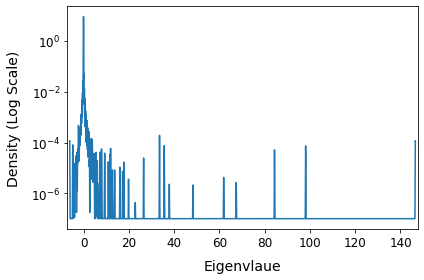

In [23]:
get_esd_plot(density_eigen, density_weight)